# 0. Import the library

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors
from collections import defaultdict

# 1. Load Data

In [2]:
animes = pd.read_feather("../input/anime-data-save-as-feather/animes.feather")
rating_df = pd.read_feather("../input/anime-data-save-as-feather/rating_df.feather")

# 2. EDA

## Metadata

In [3]:
################### get genres
Genres = defaultdict(int)
for val in animes['Genres']:
    for v in val.split(','):
        Genres[ v.strip() ] += 1

#print("animes genres = ", list(dict(Genres).keys()) )

################### get episodes
Episodes = defaultdict(int)
for val in animes['Episodes']:
    if val == "Unknown" : 
        Episodes[ 0 ] += 1;
    else : Episodes[ int(val.strip()) ] += 1

#print("animes Episodes = ", list(dict(Episodes)) )
#for val in sorted(dict(Episodes).keys()):  print(val, Episodes[val] )

################### get durations
Durations = defaultdict(int)
for val in animes['Duration']:
    Durations[ val ] += 1

#print("animes Durations = ", list(dict(Durations)) )

################### get Types
Types = defaultdict(int)
for val in animes['Type']:
    Types[ val.strip() ] += 1
#print("animes types = ", list(dict(Types)) )

In [4]:
################### create release date
years  = []
months = []
for val in animes['Aired']:
    vr = val.split()
    y = 'Unknown'
    m = 'Unknown'
    for v in vr:
        if v.isdigit() and len(v) == 4 :
            y = v
            break
    for v in vr:
        if not v.isdigit() and len(v) >= 3 and v[0].isupper() and v != 'Unknown' :
            m = v[:3]
            break
        
    years += [ y ]
    months += [ m ]
animes['Year'] = years
animes['Month'] = months

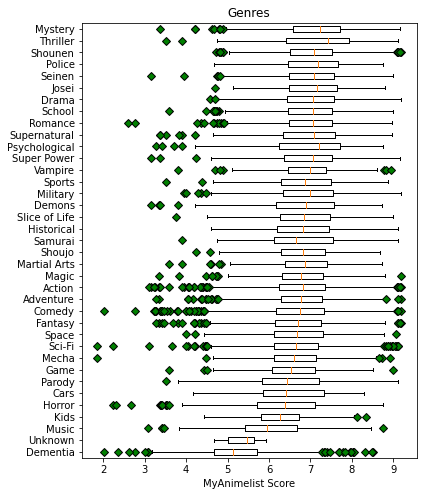

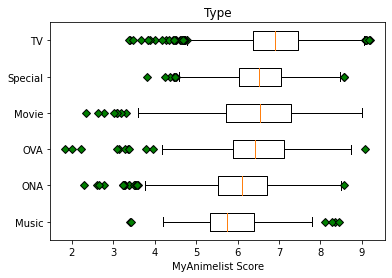

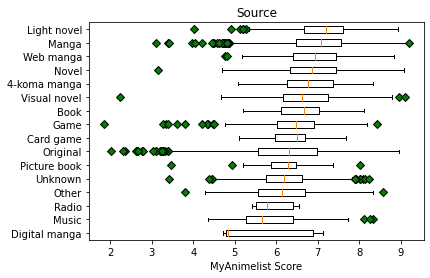

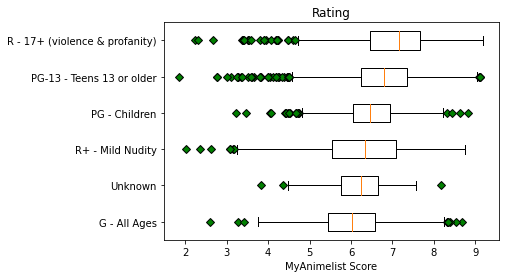

In [5]:
###################################### Plots
score_var  = 'Score'
for f in ['Genres', 'Type', 'Source', 'Rating'] :
    animes[f] = animes[f].str.split(', ')
    datas = defaultdict(list)
    for score, types in zip( animes[score_var], animes[f] ):
        if score == "Unknown": continue
        for type in types :
            datas[ type ] += [ float(score) ]

    sorted_datas = sorted(datas.items(), key=lambda f : sum(f[1])/len(f[1]) )

    fig, ax = plt.subplots()
    ax.set_title( f )
    if f == "Genres" : 
        ax.set_title( "Genres" )
        fig.set_figheight( 2*fig.get_figheight() )
    ax.boxplot( [f[1] for f in sorted_datas], vert=False, flierprops=dict(markerfacecolor='g', marker='D') )
    ax.set_yticklabels( [f[0] for f in sorted_datas] )
    ax.set_xlabel('MyAnimelist Score')
    plt.show()

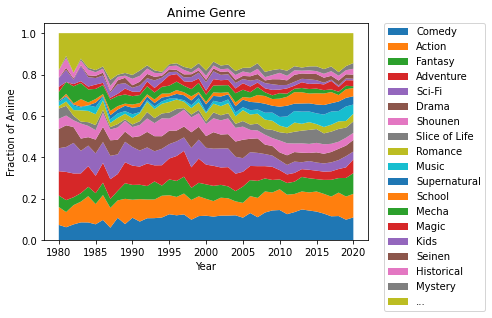

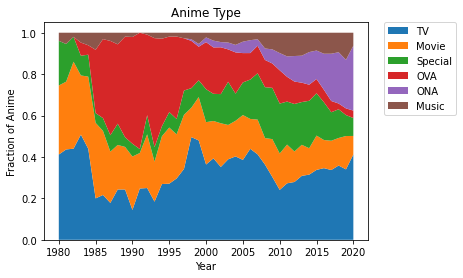

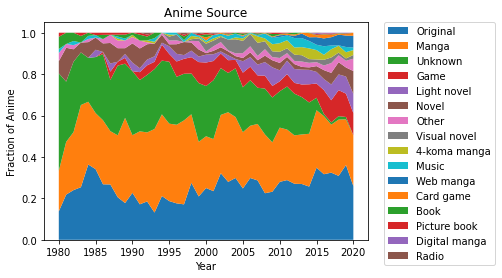

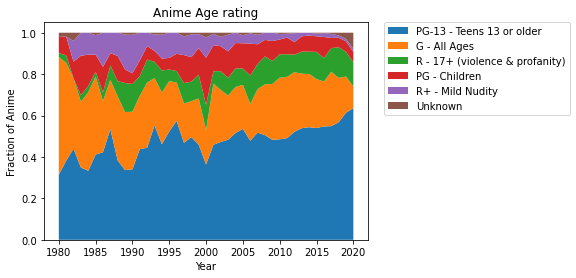

In [6]:
################### Stackplots per Year
for f in ['Genres', 'Type', 'Source', 'Rating'] :
    datas = {}
    for year in [ str(y) for y in range(1910, 2030) ]:
        datas[ year ] = defaultdict(list)

    all_types = []
    for score, types, year in zip( animes[score_var], animes[f], animes["Year"] ):
        if year == "Unknown":  continue
        if score == "Unknown": continue
        for type in types :
            datas[year][ type ] += [ float(score) ]
            all_types += [ type ]

    x_data = defaultdict(list)
    for type in list(set(all_types)):
        for year in [ str(y) for y in range(1980, 2021) ]:
            x_data[ type ] += [ len( datas[ year ][ type ] ) ]
    sorted_datas = sorted(x_data.items(), key=lambda f : -sum(f[1]) )

    for i in range(len(sorted_datas[0][1])) :
        summ = sum( [ ff[1][i] for ff in sorted_datas ] )
        for j in range(len(sorted_datas)):
            sorted_datas[j][1][i] /= summ

    if len(sorted_datas) > 18:
        others = []
        for i in range(len(sorted_datas[0][1])) :
            summ = sum( [ ff[1][i] for ff in sorted_datas[18:] ] )
            others += [ summ ]
        sorted_datas = sorted_datas[:18] + [ ["...", others] ]

    fig, ax = plt.subplots()
    ax.stackplot([y for y in range(1980, 2021)], [f[1] for f in sorted_datas], labels=[f[0] for f in sorted_datas] )
    ax.set_xlabel('Year')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.subplots_adjust(right=0.5)
    fig.set_figwidth( 2*fig.get_figwidth() )

    ax.set_title( "Anime " + f )
    if f == "Genres" :    ax.set_title( "Anime Genre" )
    if f == "Rating" :     ax.set_title( "Anime Age rating" )
    if f == 'Year_class' : ax.set_title( "Anime Release year" )
    if f == 'Month' :      ax.set_title( "Anime Release month" )

    ax.set_ylabel('Fraction of Anime')

Text(0.5, 1.0, '% of Anime per Number of episodes')

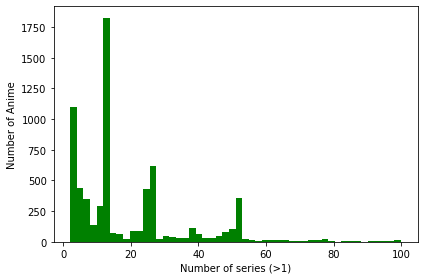

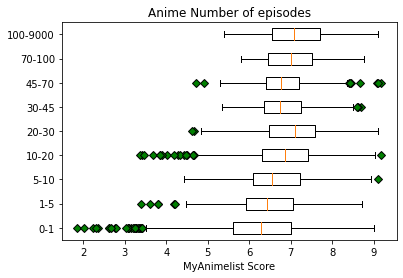

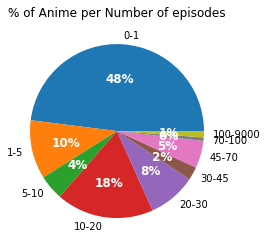

In [7]:
################### check number of 'Episodes'
N_episodes_regions = [1, 5, 10, 20, 30, 45, 70, 100, 9000]
for N in N_episodes_regions :
    animes[ 'Episodes_' + str(N) ] = 0

episodes = []
for i in animes.index:
    eps = animes.at[i, 'Episodes']
    if eps == "Unknown" : continue
    eps = int(eps)
    for N in N_episodes_regions :
        if eps > N : continue
        animes.at[i, 'Episodes_' + str(N) ] = 1
        break
    if eps < 2 : continue
    if eps > 100 : continue
    episodes += [ eps ]

fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(episodes, bins=50, facecolor='g')
ax.set_xlabel('Number of series (>1)')
ax.set_ylabel('Number of Anime')

datas = defaultdict(list)
for i, N in enumerate(N_episodes_regions) :
    title  = 'Episodes_' + str(N)
    xtitle = str( ([0] + N_episodes_regions)[i] ) + "-" + str(N_episodes_regions[i])
    tmp_df = animes[animes[title] == 1]
    tmp_df = tmp_df[tmp_df["Score"] != "Unknown"]
    datas[ xtitle ] = tmp_df["Score"].tolist()
# print( datas )

sorted_datas = sorted(datas.items(), key=lambda f : int(f[0].split("-")[0]) )

fig, ax = plt.subplots()
ax.set_title( "Anime Number of episodes" )
ax.boxplot( [[float(x) for x in f[1]] for f in sorted_datas], vert=False, flierprops=dict(markerfacecolor='g', marker='D') )
ax.set_yticklabels( [f[0] for f in sorted_datas] )
ax.set_xlabel('MyAnimelist Score')

# pie
fig, ax = plt.subplots()

data_x = [len(f[1]) for f in sorted_datas]
data_y = [f[0] for f in sorted_datas]

patches, texts, autotexts = ax.pie(data_x, labels = data_y, autopct='%d%%')
ax.set(aspect="equal", title="Fraction of Anime films")
plt.setp(autotexts, size=12, weight="bold", color="white")

plt.title("% of Anime per Number of episodes")

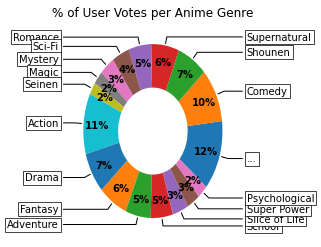

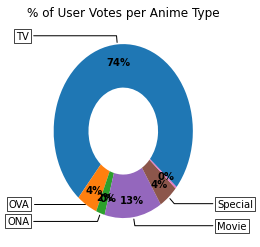

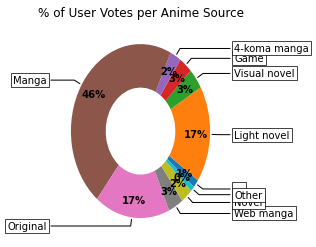

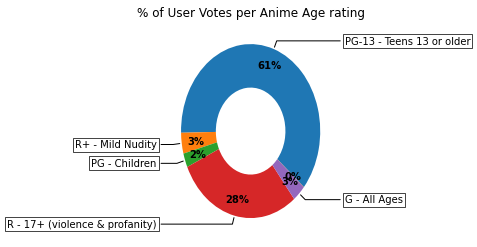

In [8]:
for f in ['Genres', 'Type', 'Source', 'Rating'] : 
    datas = defaultdict(list)
    for score, types in zip( animes["N_votes"], animes[f] ):
        if score == "Unknown": continue
        for type in types :datas[ type ] += [ float(score) ]

    sorted_datas = sorted(datas.items(), key=lambda f : sum(f[1]) )
    data_x = [sum(f[1]) for f in sorted_datas]
    data_xx = [len(f[1]) for f in sorted_datas]
    data_y = [f[0] for f in sorted_datas]

    if f == 'Source':
        data_x = data_x[-9:] + [ sum(data_x[:-9]) ]
        data_y = data_y[-9:] + [ '...' ]
    if f == 'Genres':
        data_x = data_x[-16:] + [ sum(data_x[:-18]) ]
        data_y = data_y[-16:] + [ '...' ]
    if f == 'Year_class':
        data_x = data_x[-8:] + [ sum(data_x[:-8]) ]
        data_y = data_y[-8:] + [ '...' ]

    data_x = list(reversed(data_x))
    data_y = list(reversed(data_y))

    fig, ax = plt.subplots()
    data_y = data_y[::2] + list(data_y[1::2])
    wedges, texts, autotexts = ax.pie(data_x[::2] + list(data_x[1::2]), wedgeprops=dict(width=0.5), startangle=-40, autopct='%d%%', pctdistance=0.80)

    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if data_y[i] == "Unknown" : continue
        if data_y[i] == "Music" : continue
        extra = 0
        if data_y[i] == "Rx - Hentai" : extra = 0.1
        if data_y[i] == "OVA" : extra = 0.1
        ax.annotate(data_y[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.1*y+extra), horizontalalignment=horizontalalignment, **kw)
  
    plt.setp(autotexts, size=10, weight="bold", color="black")
    ax.set_aspect(aspect=1.25)

    plt.title("% of User Votes per Anime " + f)
    if f == "Genres" : plt.title( "% of User Votes per Anime Genre" )
    if f == "Rating"  : plt.title( "% of User Votes per Anime Age rating" )
    if f == 'Year_class' : plt.title( "% of User Votes per Anime Release year" )
    if f == 'Month' :      plt.title( "% of User Votes per Anime Release month" )

## Rating

### a. Rating Distribution

<AxesSubplot:ylabel='rating'>

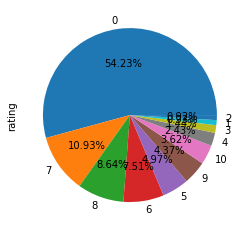

In [9]:
rating = rating_df['rating'].value_counts()
rating_distribution = rating.to_frame().reset_index()
rating.plot.pie(autopct='%.2f%%')

In [10]:
rating_distribution.columns=['rating','Counts']

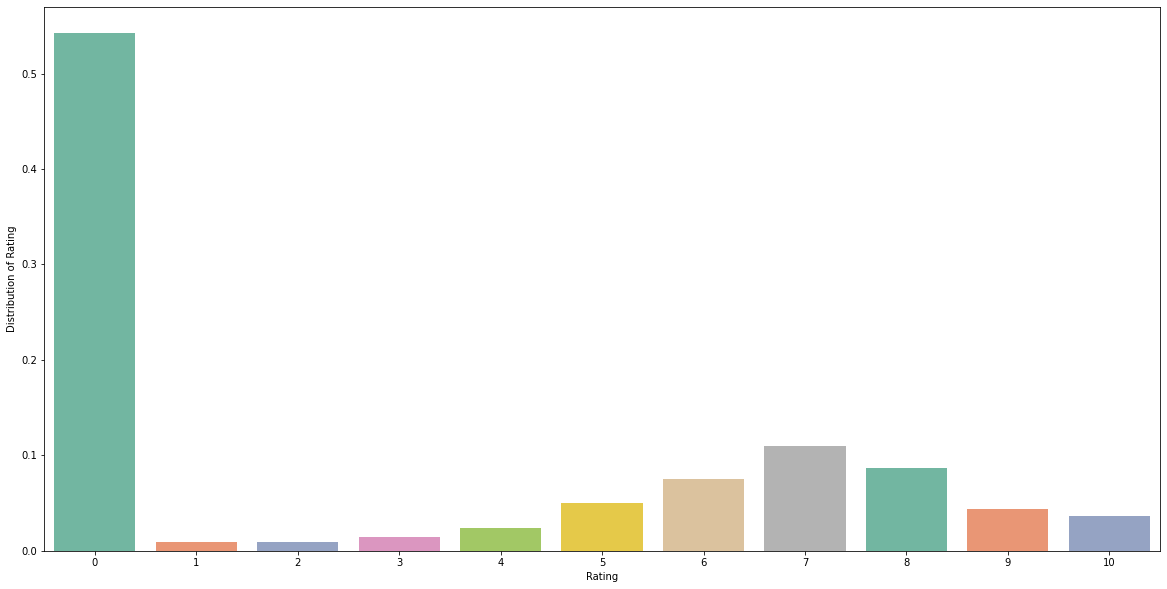

In [11]:
fig = plt.subplots(figsize=(20,10))
ax = sns.barplot(data=rating_distribution, x=rating_distribution['rating'], y=rating_distribution['Counts']/rating_distribution['Counts'].sum(),palette='Set2')
ax.set(xlabel="Rating",ylabel='Distribution of Rating')
#plt.figure(figsize=(30,10))
plt.show()

### b. Top Rating Count Distribution grouped by Anime

In [12]:
train_groupby_products_Ratings = rating_df.groupby('anime_id')['rating']

In [13]:
rating_animes= pd.DataFrame(train_groupby_products_Ratings.count()).reset_index()

In [14]:
rating_animes_sort = rating_animes.sort_values(by='rating', ascending=False)
rating_animes_sort

,anime_id,rating
3554,6547,1976
4444,9253,1974
1151,1535,1964
2808,4224,1960
3066,5081,1956
...,...,...
15026,47634,1
14330,41750,1
15059,48466,1
14171,41250,1


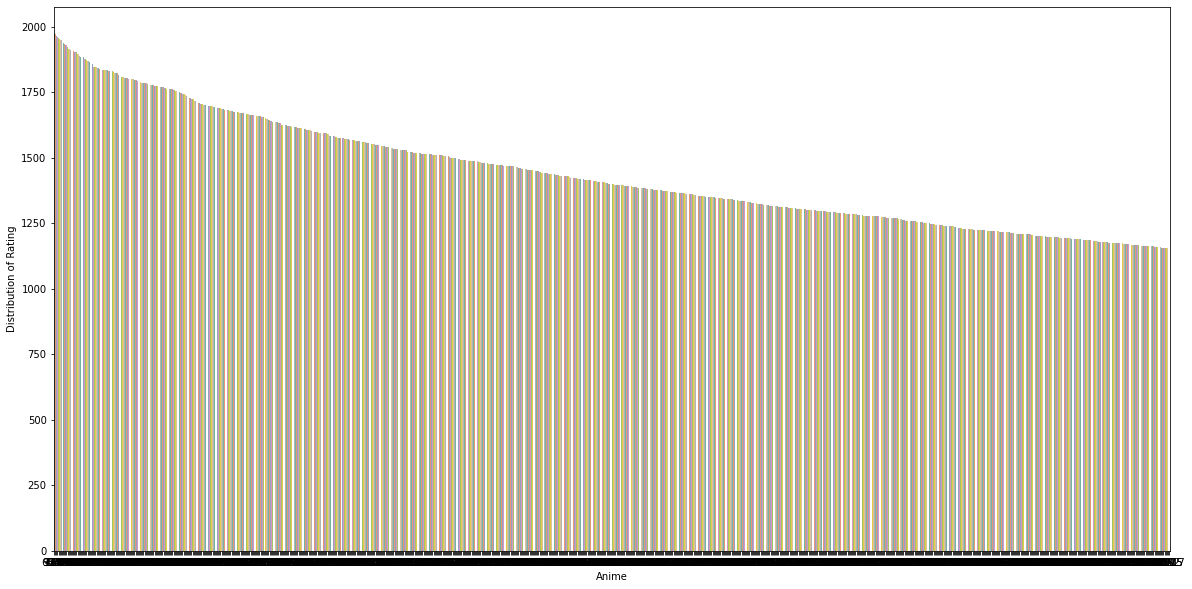

In [15]:
fig = plt.subplots(figsize=(20,10))
ax = sns.barplot(data=rating_animes_sort,x=rating_animes_sort['anime_id'][:1000], y=rating_animes_sort['rating'],palette='Set2',order=rating_animes_sort['anime_id'][:1000])
ax.set(xlabel="Anime",ylabel='Distribution of Rating')
#plt.figure(figsize=(30,10))
plt.show()

### c. Top Rating Count Distribution grouped by Users

In [16]:
train_groupby_users_Ratings = rating_df.groupby('user_id')['rating']

In [17]:
rating_users = pd.DataFrame(train_groupby_users_Ratings.count().reset_index())

In [18]:
rating_users_sort =rating_users.sort_values(by='rating', ascending=False)
rating_users_sort

,user_id,rating
137,20807,15056
1000,140590,15044
1966,281232,15043
1037,147331,15036
935,131988,15030
...,...,...
756,105973,904
930,131420,886
1859,266927,825
1085,154328,704


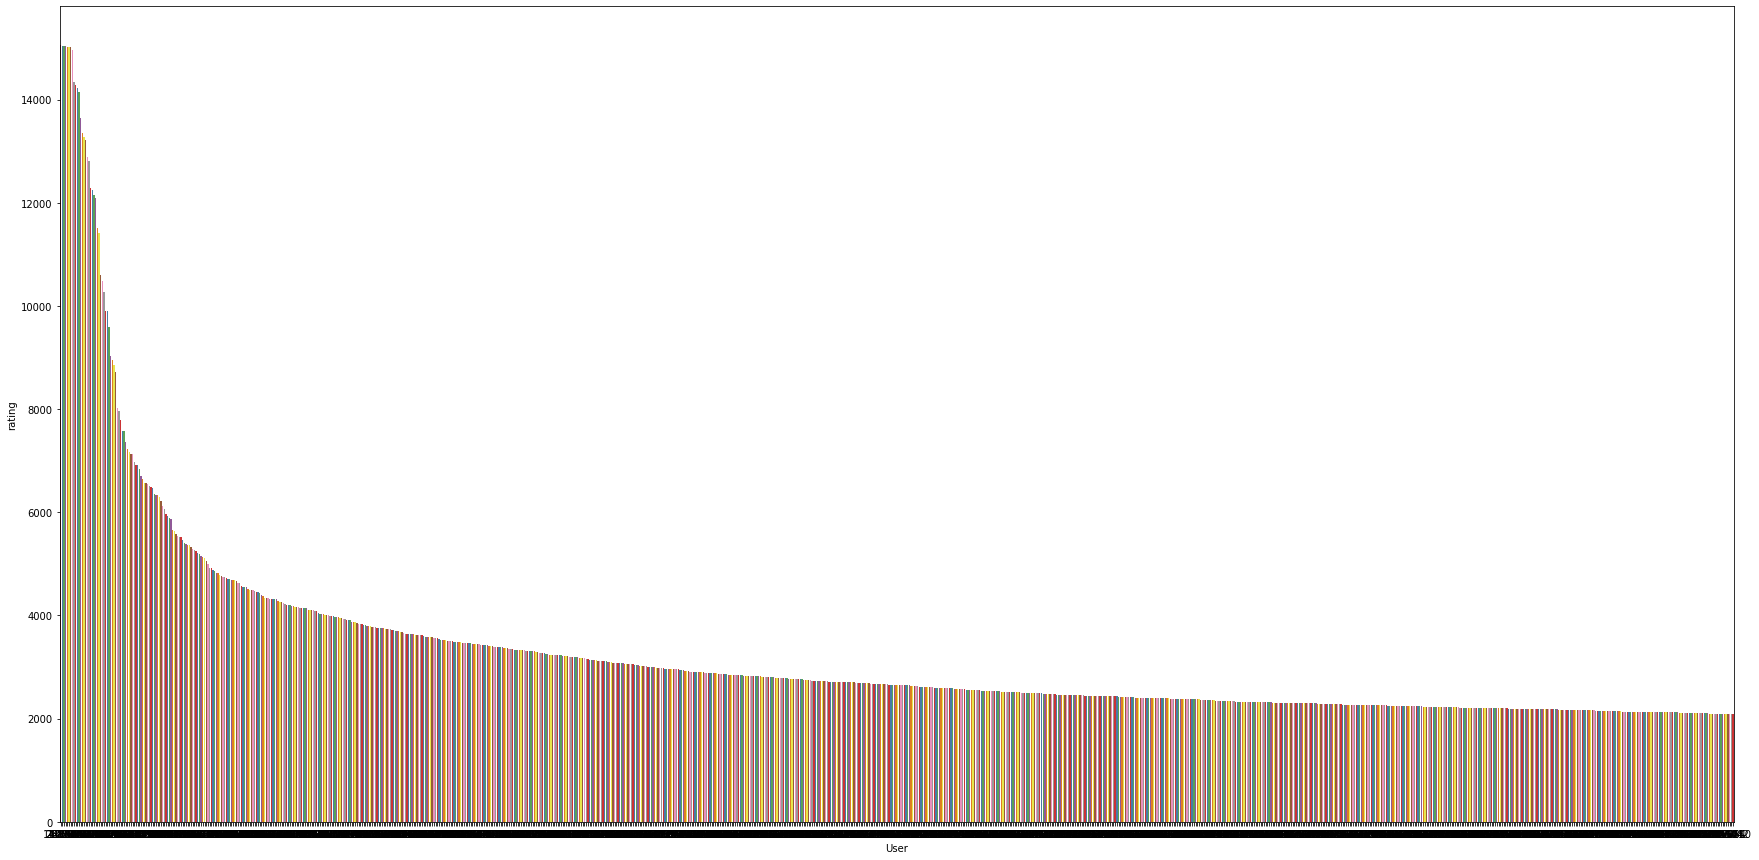

In [19]:
fig = plt.subplots(figsize=(30,15))
ax = sns.barplot(data=rating_users_sort,x=rating_users_sort['user_id'][:1000], y=rating_users_sort['rating'],palette='Set1', order=rating_users_sort['user_id'][:1000])
ax.set(xlabel="User")
#plt.figure(figsize=(30,10))
plt.show()

### d. Mean Rating Distribution grouped by Animes

In [20]:
train_groupby_products_Ratings

In [21]:
Anime_mean = pd.DataFrame(train_groupby_products_Ratings.mean())
Anime_mean

,rating
anime_id,
1,5.685559
5,4.928038
6,4.671598
7,2.704408
8,2.386308
...,...
48481,0.000000
48483,0.000000
48488,0.000000


In [22]:
Anime_mean_sort = Anime_mean.sort_values(by='rating', ascending=False).reset_index()

In [23]:
Anime_mean_sort.rename(columns={'rating':'rating mean'}, inplace=True)

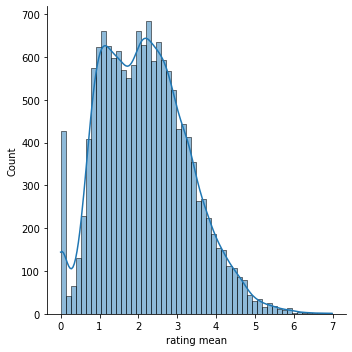

In [24]:
#fig = plt.figure(figsize=(30,15))
ax = sns.displot(data=Anime_mean_sort,x=Anime_mean_sort['rating mean'], palette='Set1',kde=True)
#ax.set(xlabel="rating mean")
#plt.show()

### e. Mean Rating - Rating Count Distribution grouped by Animes

In [25]:
temp = pd.merge(Anime_mean_sort,train_groupby_products_Ratings.count(),on='anime_id')
temp

,anime_id,rating mean,rating
0,1535,6.980652,1964
1,30276,6.922996,1896
2,16498,6.811891,1951
3,5114,6.769430,1930
4,199,6.674482,1834
...,...,...,...
15062,42940,0.000000,182
15063,42938,0.000000,439
15064,40087,0.000000,17
15065,42916,0.000000,506


<Figure size 2160x1080 with 0 Axes>

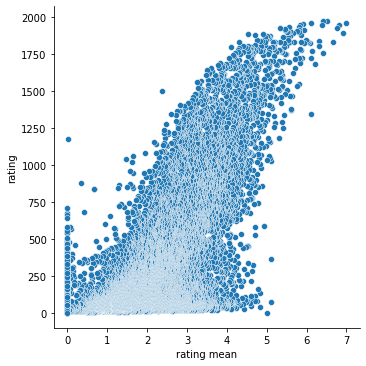

In [26]:
plt.figure(figsize=(30,15))
ax = sns.relplot(data=temp,x=temp['rating mean'],y =temp['rating'])

### f. Mean Rating Distribution grouped by users

In [27]:
train_groupby_users_Ratings

In [28]:
user_mean = pd.DataFrame(train_groupby_users_Ratings.mean())
user_mean

,rating
user_id,
146,1.599635
240,0.837724
436,2.494055
446,3.497459
781,4.754462
...,...
290269,6.465915
290342,2.038545
290416,1.448988


In [29]:
user_mean_sort = user_mean.sort_values(by='rating', ascending=False).reset_index()

In [30]:
user_mean_sort.rename(columns={'rating':'rating mean'}, inplace=True)

<Figure size 2160x1080 with 0 Axes>

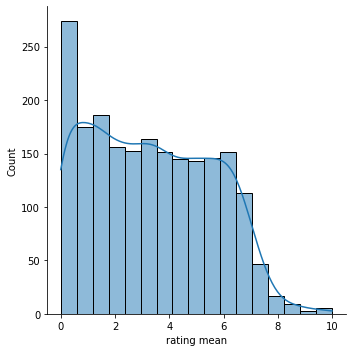

In [31]:
plt.figure(figsize=(30,15))
ax = sns.displot(data=user_mean_sort,x=user_mean_sort['rating mean'], palette='Set1',kde=True)
#ax.set(xlabel="rating mean")
#plt.show()

### g. Mean Rating - Rating Count Distribution grouped by Users

In [32]:
temp2 = pd.merge(user_mean_sort,train_groupby_users_Ratings.count(),on='user_id')
temp2

,user_id,rating mean,rating
0,154328,10.000000,704
1,39649,9.991981,1247
2,162615,9.772659,13284
3,43578,9.724638,3450
4,57684,9.626717,6333
...,...,...,...
2032,186079,0.000000,2372
2033,29746,0.000000,1762
2034,199851,0.000000,1533
2035,212322,0.000000,1771


<Figure size 2160x1080 with 0 Axes>

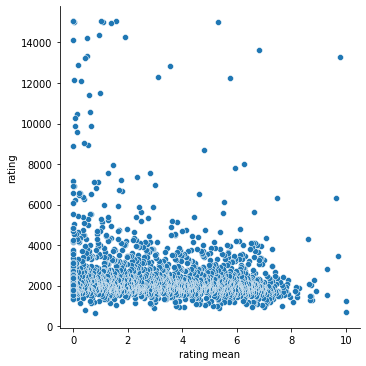

In [33]:
plt.figure(figsize=(30,15))
ax = sns.relplot(data=temp2,x=temp2['rating mean'],y =temp2['rating'])